# Trabalho 2 da disciplina de Aprendizado de Máquina: Análise de sentimento em tweets


In [2]:
""" Importando as Bibliotecas """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatLogSlider


#Biblotecas sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

from sklearn.compose import make_column_transformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

from scipy.special import expit as sigmoid

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import balanced_accuracy_score

## 1 - Carregar os dados e criar a variável alvo

In [3]:
data = pd.read_csv('/kaggle/input/tweetsreviews/Tweets.csv')
data.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [4]:
data.shape

(27481, 4)

In [5]:
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


### Criando variavel alvo

In [6]:
#Caso a variavel sentiment for negative assumimos 1 caso contrátio será assumido o valor 0 na coluna alvo
data.loc[data['sentiment'] == 'negative', 'alvo'] = 1
data.loc[data['sentiment'] != 'negative', 'alvo'] = 0
data.head(10)

,textID,text,selected_text,sentiment,alvo
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,1.0
2,088c60f138,my boss is bullying me...,bullying me,negative,1.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,1.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,1.0
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,0.0
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,0.0
7,50e14c0bb8,Soooo high,Soooo high,neutral,0.0
8,e050245fbd,Both of you,Both of you,neutral,0.0
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,0.0


## 2 - EDA inicial

### a. Observe se existem dados faltantes ou duplicados


#### i) Dados duplicados

In [7]:
duplicateRows = data[data.duplicated()] #Estou criando um novo dataframe com apenas as linhas duplicadas para criar um dataframe sem as linhas duplicadas bastaria colocar um '~' dentro dos []
duplicateRows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   textID         0 non-null      object 
 1   text           0 non-null      object 
 2   selected_text  0 non-null      object 
 3   sentiment      0 non-null      object 
 4   alvo           0 non-null      float64
dtypes: float64(1), object(4)
memory usage: 0.0+ bytes


  Podemos verificar que não existem dados faltantes no dataset

#### ii) Dados faltantes

In [8]:
lista = data.isna().sum()
print(lista.keys(), lista.values)

Index(['textID', 'text', 'selected_text', 'sentiment', 'alvo'], dtype='object') [0 1 1 0 0]


  Verificasse 2 NaN um em 'text' e outro em 'selected_text'

### b. Plote um histograma do número dos caracteres dos reviews


In [9]:
caracteres = data['text'].str.len()

<AxesSubplot:>

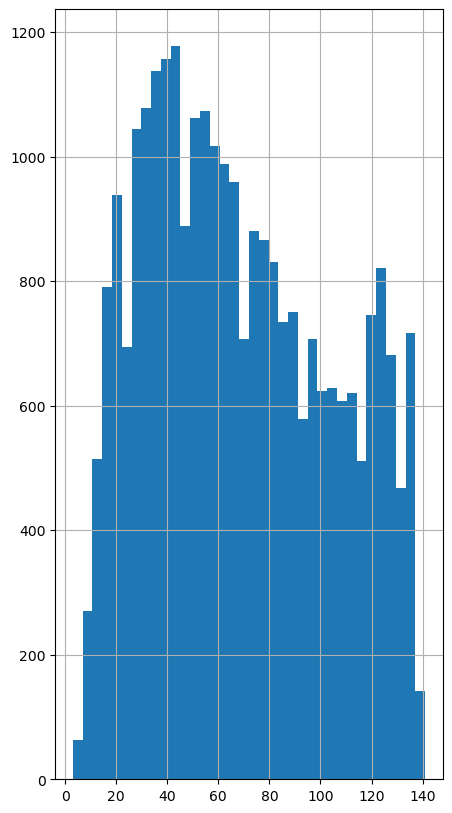

In [10]:
caracteres.hist(bins='auto', figsize=(5,10))

### c. Plote um histograma do número de palavras dos reviews


In [11]:
count = data['text'].apply(lambda x: len(str(x).split()))

<AxesSubplot:>

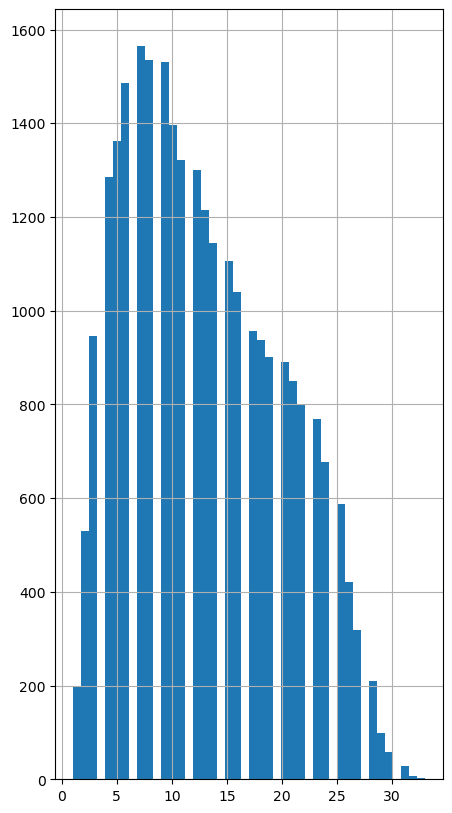

In [12]:
count.hist(bins='auto', figsize=(5,10))

### d. Mostre os 5 maiores e menores comentários


In [13]:
caracteres_sorted = caracteres.sort_values(ascending = False)

In [14]:
print("Os 5 maiores comentários:")
print(data['text'][caracteres_sorted.index].head(5))
print("Os 5 menores comentários:")
print(data['text'][caracteres_sorted.index].tail(5))


Os 5 maiores comentários:
3138     Is so freaking bored on the bus. Hate being po...
27318    just saw an advert for ATTICS TO EDEN on tv  o...
13896    Feeling madly sorry for myself... - ï¿½Iï¿½M S...
2582     TODAy SUCKs - kisskass19: ï¿½you and katey bro...
27067    Jamie @ Sean Cody, up for some angry ****?: Ja...
Name: text, dtype: object
Os 5 menores comentários:
26005      ?
14339     ow
641       no
11524     aw
314      NaN
Name: text, dtype: object


### e. Mostre um WordCloud com todo o texto dos reviews (utilize a função WordCloud da biblioteca wordcloud)


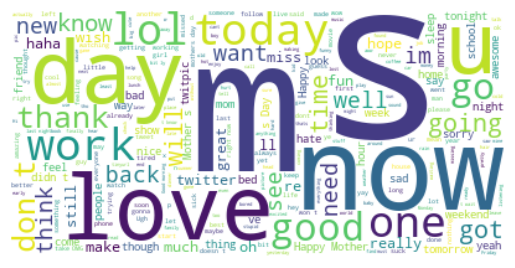

In [15]:
from wordcloud import WordCloud

# Concatenar todos os reviews em uma única string
texto = " ".join(review for review in data['text'].astype(str))


# Criar um objeto WordCloud
wordcloud = WordCloud( background_color="white", max_words=10000).generate(texto)

# Plote o WordCloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### f. Mostre a distribuição da variável alvo através de um gráfico de barras

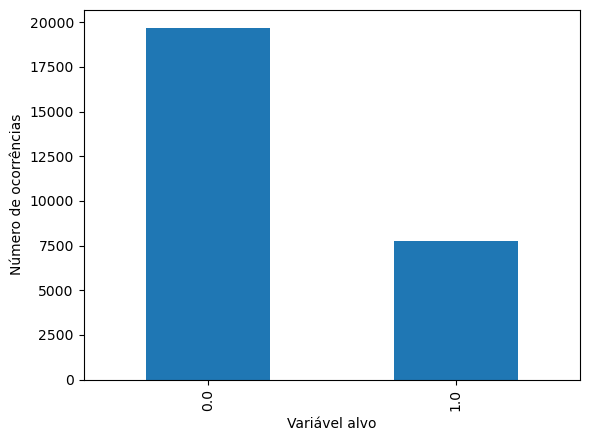

In [16]:
counts = data['alvo'].value_counts()

# Plotar um gráfico de barras
counts.plot(kind='bar')

# Adicionar rótulos nos eixos
plt.xlabel('Variável alvo')
plt.ylabel('Número de ocorrências')

# Mostrar o gráfico
plt.show()

  Podemos ver que temos mais reviews neutras e positivas do que negativas (quase o triplo)

## 3 - Limpeza e separação dos dados


### a. (Se necessário) Trate os dados faltantes ou duplicados


  Como só temos dois dados faltantes e nenhum duplicado irei trabalhar em cima dos mesmos


In [17]:
data = data.dropna()

In [18]:
data.shape

(27480, 5)

  Como podemos ver a função dropna() do pandas retirou apenas uma linha do dataset

Irei realizar a diminuição do dataset assim como no trabalho 1 pois os treinamentos estavam demorando um tempo muito longo (maiores que 20 minutos) no kaggle e também no meu computador

In [19]:
#Utilizando o código fornecido
# parâmetros
num_instancias_por_classe = 3000
# cria datasets auxiliares para reduzir o dataset para o tamanho desejado
df_temp = []
for classe in data['alvo'].unique():
    # seleciona parcela do dataset da classe desejada
    temp = data[data['alvo'] == classe].sample(n=num_instancias_por_classe,random_state=42)
    # salva para concatenar no final
    df_temp.append(temp)
    # concatena todos as subparcelas no dataset com tamanho desejado
data_small = pd.concat(df_temp, axis=0)
# confirma a divisão correta por classe
print('-'*30)
print('#instâncias em relação a coluna name')
print(data_small['alvo'].value_counts())
print('-'*30)
# mostra o dataset
data_small

------------------------------
#instâncias em relação a coluna name
0.0    3000
1.0    3000
Name: alvo, dtype: int64
------------------------------


,textID,text,selected_text,sentiment,alvo
23739,0f0ce4a8fb,I`m so pumped for the day!,I`m so pumped for the day!,neutral,0.0
7489,3f629a6a8e,Having serious technical issues in the studio ...,Having serious technical issues in the studio ...,neutral,0.0
19696,c3510eac7f,working on a layout 4 my page....prom dress is...,working on a layout 4 my page....prom dress is...,neutral,0.0
20273,1af710051b,_v haha i was in your boat yesterday.. you`ll...,haha,positive,0.0
2412,21e1d2e745,where did the rain go??,where did the rain go??,neutral,0.0
...,...,...,...,...,...
9727,da608fb08e,"omg!!!! I feel bad, .Was it good? ...","I feel bad,",negative,1.0
7513,8375f8713a,HIII!!!! i`ve missed you just bored....what...,i`ve missed you just bore,negative,1.0
24901,ddbfe60ea3,"Nicky, I LAND at 10pm, it will be like 10:40 ...",UGH!,negative,1.0
18168,498145e798,"omfg, my head","omfg, my head",negative,1.0


### b. Separe 20% do conjunto para teste utilizando a divisão estratificada com base no target


In [20]:
""" Realizando uma divisão utilizadno a função train_test_split em cima do dataframe data
Com um test_size de 0.2, estratificada no atributo alvo e com o random_state de 42 """
df_train, df_test = train_test_split(data_small, test_size=0.2, stratify=data_small['alvo'], random_state=42)

### c. Para o conjunto de validação você pode escolher:


#### i. Separar um conjunto hold-out; ou


In [21]:
""" Realizando uma divisão utilizadno a função train_test_split em cima do dataframe df_train
Com um test_size de 0.5, estratificada no atributo alvo e com o random_state de 42 """
df_train, df_validation = train_test_split(df_train, test_size=1/2, stratify=df_train['alvo'], random_state=42)

In [22]:
print(df_train.shape)
print(df_validation.shape)
print(df_test.shape)

(2400, 5)
(2400, 5)
(1200, 5)


Escolhi realizar a separação com o método hold-out e escolhi 40-40-20 entre treino, validação e teste

### d. Separe os dados entre X e y para cada subconjunto de dados, similar a como feito no trabalho anterior

In [23]:
target = 'alvo' #Definindo a coluna que será predita
X_train = df_train['text'] # X vai ser à coluna text 
y_train = df_train[target] # y será apenas a coluna target


X_test = df_test['text']
y_test = df_test[target]


X_validation = df_validation['text']
y_validation = df_validation[target]

## 4. Pipeline de pré-processamento


### a. Defina a pipeline de pré-processamento


#### i. Utilize somente o CountVectorizer com os parâmetros padrão


In [24]:
vectorizer = CountVectorizer() # Inicializando o CountVectorizer com os parametros padrão
preprocess = make_column_transformer((vectorizer, ['text']))

### b. Se estiver utilizando conjunto hold-out você pode pré-processá-los aqui se preferir

In [25]:
vectorizer.fit(X_train)

CountVectorizer()

In [26]:
def transformed(X):
  return pd.DataFrame.sparse.from_spmatrix(
            vectorizer.transform(X), 
            columns=vectorizer.get_feature_names_out())

In [27]:
X_test = transformed(X_test)
X_train = transformed(X_train)
X_validation = transformed(X_validation)

print(X_test.head())
print(X_train.head())



   00  00am  02mxjj  04  05  05ixbj  06  07  09  0xhu5j  ...  ½27  ½80  ½jï  \
0   0     0       0   0   0       0   0   0   0       0  ...    0    0    0   
1   0     0       0   0   0       0   0   0   0       0  ...    0    0    0   
2   0     0       0   0   0       0   0   0   0       0  ...    0    0    0   
3   0     0       0   0   0       0   0   0   0       0  ...    0    0    0   
4   0     0       0   0   0       0   0   0   0       0  ...    0    0    0   

   ½ltermand  ½m  ½mee  ½n  ½s  ½t  ½ï  
0          0   0     0   0   0   0   0  
1          0   0     0   0   0   0   0  
2          0   0     0   0   0   0   0  
3          0   0     0   0   0   0   0  
4          0   0     0   0   0   0   0  

[5 rows x 5659 columns]
   00  00am  02mxjj  04  05  05ixbj  06  07  09  0xhu5j  ...  ½27  ½80  ½jï  \
0   0     0       0   0   0       0   0   0   0       0  ...    0    0    0   
1   0     0       0   0   0       0   0   0   0       0  ...    0    0    0   
2   0     0      

## 5. Treinamento e seleção de hiperparâmetros: treine os modelos a seguir, observe os resultados da acurácia balanceada tanto para o conjunto de treinamento como o de validação e realize a otimização de hiperparâmetros


### a. Regressão Logística


#### i. Treine para o modelo regressão logística com os parâmetros padrão


In [48]:
model = LogisticRegression(penalty='none')
model.fit(X_train, y_train)
print(f'b = {model.intercept_[0]}, w = {model.coef_[0]}')
print('Iterations:', model.n_iter_[0])
p = model.predict_proba(X_train)[:, 1]
cost = np.mean(-y_train*np.log(p + 1e-200) - (1 - y_train)*np.log(1 - p + 1e-200))
print('Cost:', cost)
print(f'Train balanced accuracy: {balanced_accuracy_score(y_train, model.predict(X_train)):.1%}')
print(f' Vali balanced accuracy: {balanced_accuracy_score(y_validation, model.predict(X_validation)):.1%}')
print(f' Test balanced accuracy: {balanced_accuracy_score(y_test, model.predict(X_test)):.1%}')

b = 9.365004516425264, w = [-47.98312318   4.31123267   6.0938778  ...  26.35526637  26.35526637
 -17.11201912]
Iterations: 52
Cost: 1.1315048489580424e-07
Train balanced accuracy: 100.0%
 Vali balanced accuracy: 68.7%
 Test balanced accuracy: 71.9%


  Podemos ver que para os parametros padroes do algoritmo logistic regression o proprio sckit learn da um aviso que atingiu o numero maximo de iteracoes e podemos concluir que os hiperparametros nao estao bem definidos

#### ii. Realize a otimização de hiperparâmetros utilizando grid search (Repita o mesmo processo para os próximos modelos)


In [49]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
def grid_search(model, param_grid, X_train, y_train, X_val, y_val):
    val_index = [-1]*len(X_train) + [0]*len(X_val)
    gs = GridSearchCV(model, param_grid, refit=False, cv=PredefinedSplit(val_index))
    gs.fit(np.r_[X_train, X_val], np.r_[y_train, y_val])
    return gs

In [ ]:
param_grid = { 'C': 10.0**np.arange(-3, 3.01, 1),
               'solver': ('lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga')}
gs = grid_search(LogisticRegression(max_iter = 200), param_grid, X_train, y_train, X_validation, y_validation)
print('best_score:', gs.best_score_)
print('best_params:', gs.best_params_)

    Melhores parametros C = 1.0 e solver = lbfgs tive que fixar o numero de max_iter pois nenhum dos três métodos eu conseguia rodar (pc próprio, colabs ou kaggle)

### b. SVM com kernel RBF


In [ ]:


param_grid = { 'C': np.arange(1000, 10000, 1000),
               'degree': np.arange(1, 10, 1)}
gs = grid_search(SVC(kernel='rbf',gamma = 'auto', coef0 = 1,cache_size = 8000), param_grid, X_train, y_train, X_validation, y_validation)
print('best_score:', gs.best_score_)
print('best_params:', gs.best_params_)


    best_params: {'C': 1000.0, 'degree': 1} aumentei o número de ram utilizado e consegui rodar no kaggle depois de 3h

### c. Árvore de Decisão


In [47]:

model = DecisionTreeRegressor(random_state=0, max_depth = 80)
model.fit(X_train, y_train)

print(f'Depth: {model.get_depth()}')
print(f'Number of leaves: {model.get_n_leaves()}')

threshold = 0.5  
y_train_binary = (model.predict(X_train) > threshold).astype(int)
y_validation_binary = (model.predict(X_validation) > threshold).astype(int)
y_test_binary = (model.predict(X_test) > threshold).astype(int)

print(f'Train balanced accuracy: {balanced_accuracy_score(y_train, y_train_binary):.1%}')
print(f' Vali balanced accuracy: {balanced_accuracy_score(y_validation, y_validation_binary):.1%}')
print(f' Test balanced accuracy: {balanced_accuracy_score(y_test, y_test_binary):.1%}')



Depth: 80
Number of leaves: 465
Train balanced accuracy: 96.4%
 Vali balanced accuracy: 67.0%
 Test balanced accuracy: 68.6%


In [48]:
model.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [ ]:
"""
from sklearn.tree import DecisionTreeRegressor
param_grid = { 'max_depth': np.arange(1, 5, 1),
              'min_samples_split': np.arange(2, 52, 5),
              'min_samples_leaf': np.arange(1, 20, 5),
              'max_leaf_nodes': np.arange(2, 120, 10),
              'min_impurity_decrease': np.arange(0.0, 6, 2),
              'ccp_alpha': np.arange(0, 6, 2)}
gs = grid_search(DecisionTreeRegressor(random_state=0), param_grid, X_train, y_train, X_validation, y_validation)
print('best_score:', gs.best_score_)
print('best_params:', gs.best_params_)
"""

O código acima ficou 7 horas rodando e não conseguiu achar os melhores parametrôs, isso após diversas e diversas tentativas que simplesmente saturavam a memória do colab ou do kaggle e no meu computador travava e parava de funcionar, resolvi fazer a identificação dos "melhores" paramêtros assim como no trabalho 1 por conta própria, sei que não será o melhor resultado mas para conseguir terminar esse trabalho foi a solução que eu encontrei (irei utilizar o param_grid com 2 parametros por vez, irei fixar esses dois parametros e mudar para os próximos)

In [50]:
param_grid = { 'max_depth': np.arange(1, 20, 1),
              'min_samples_split': np.arange(2, 52, 5)
              }
gs = grid_search(DecisionTreeRegressor(random_state=0), param_grid, X_train, y_train, X_validation, y_validation)
print('best_score:', gs.best_score_)
print('best_params:', gs.best_params_)

best_score: 0.13342058174803884
best_params: {'max_depth': 18, 'min_samples_split': 47}


    best_params: {'max_depth': 18, 'min_samples_split': 47}

In [51]:
param_grid = { 'min_samples_leaf': np.arange(1, 20, 5),
              'max_leaf_nodes': np.arange(2, 120, 10)
              }
gs = grid_search(DecisionTreeRegressor(random_state=0, max_depth = 18, min_samples_split = 47), param_grid, X_train, y_train, X_validation, y_validation)
print('best_score:', gs.best_score_)
print('best_params:', gs.best_params_)

best_score: 0.16542682916099472
best_params: {'max_leaf_nodes': 22, 'min_samples_leaf': 1}


    best_params: {'max_leaf_nodes': 22, 'min_samples_leaf': 1}

In [52]:
param_grid = { 'min_impurity_decrease': np.arange(0.0, 6, 2),
              'ccp_alpha': np.arange(0, 6, 2)
              }
gs = grid_search(DecisionTreeRegressor(random_state=0, max_depth = 18, min_samples_split = 47,max_leaf_nodes = 22, min_samples_leaf = 1), param_grid, X_train, y_train, X_validation, y_validation)
print('best_score:', gs.best_score_)
print('best_params:', gs.best_params_)
              

best_score: 0.16542682916099472
best_params: {'ccp_alpha': 0, 'min_impurity_decrease': 0.0}


    best_params: {'ccp_alpha': 0, 'min_impurity_decrease': 0.0}

Parametros finais:
random_state=0, max_depth = 18, min_samples_split = 47,
max_leaf_nodes = 22, min_samples_leaf = 1, ccp_alpha = 0 e min_impurity_decrease = 0.

### d. Floresta Aleatória


In [30]:


#model = BaggingClassifier(DecisionTreeClassifier(max_features='auto'), n_estimators=100)
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
print(f'Val accuracy (Random Forest): {model.score(X_validation, y_validation):.2%}')

Val accuracy (Random Forest): 72.58%


In [31]:
model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [57]:
param_grid = { 'n_estimators': np.arange(100, 300, 2),
              'bootstrap' : ('True', 'False') 
              }
gs = grid_search(RandomForestClassifier(), param_grid, X_train, y_train, X_validation, y_validation)
print('best_score:', gs.best_score_)
print('best_params:', gs.best_params_)

best_score: 0.7404166666666666
best_params: {'bootstrap': 'False', 'n_estimators': 254}


    best_params: {'bootstrap': 'False', 'n_estimators': 254}

In [59]:
param_grid = { 'max_depth': np.arange(1, 20, 1),
              'min_samples_split': np.arange(2, 52, 5)
              }
gs = grid_search(RandomForestClassifier(bootstrap = False, n_estimators = 254), param_grid, X_train, y_train, X_validation, y_validation)
print('best_score:', gs.best_score_)
print('best_params:', gs.best_params_)

best_score: 0.75
best_params: {'max_depth': 11, 'min_samples_split': 42}


    best_params: {'max_depth': 11, 'min_samples_split': 42}

In [60]:
param_grid = { 'min_impurity_decrease': np.arange(0.0, 6, 2),
              'ccp_alpha': np.arange(0, 6, 2)
              }
gs = grid_search(RandomForestClassifier(bootstrap = False, n_estimators = 254,max_depth = 11, min_samples_split = 42), param_grid, X_train, y_train, X_validation, y_validation)
print('best_score:', gs.best_score_)
print('best_params:', gs.best_params_)

best_score: 0.7329166666666667
best_params: {'ccp_alpha': 0, 'min_impurity_decrease': 0.0}


    best_params: {'ccp_alpha': 0, 'min_impurity_decrease': 0.0}

In [34]:
modelRF = RandomForestClassifier(bootstrap = False, n_estimators = 254, max_depth = 11, min_samples_split = 42, ccp_alpha = 0, min_impurity_decrease = 0)
modelRF.fit(X_train,y_train)

print(f'Val accuracy (Random Forest): {modelRF.score(X_validation, y_validation):.2%}')

Val accuracy (Random Forest): 74.08%


### e. Gradient Boosting

In [32]:

model = GradientBoostingClassifier(n_estimators=36, learning_rate=0.1, n_iter_no_change=10, max_depth=5)
model.fit(X_train, y_train)
print(f'  Val accuracy: {model.score(X_validation, y_validation):.2%}')

  Val accuracy: 69.38%


In [39]:
param_grid = { 'n_estimators': np.arange(1, 100, 10),
              'learning_rate' : (0.0001, 0.0003, 0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30) 
              }
gs = grid_search(GradientBoostingClassifier(), param_grid, X_train, y_train, X_validation, y_validation)
print('best_score:', gs.best_score_)
print('best_params:', gs.best_params_)

best_score: 0.7354166666666667
best_params: {'learning_rate': 0.3, 'n_estimators': 81}


    best_params: {'learning_rate': 0.3, 'n_estimators': 81}


In [33]:
param_grid = { 'n_iter_no_change' : np.arange(10,100,10),
              'max_depth' : (3,6,9,12,15,18,21,24,27)
              }
gs = grid_search(GradientBoostingClassifier(n_estimators = 81, learning_rate = 0.3), param_grid, X_train, y_train, X_validation, y_validation)
print('best_score:', gs.best_score_)
print('best_params:', gs.best_params_)

best_score: 0.7366666666666667
best_params: {'max_depth': 15, 'n_iter_no_change': 50}


    best_params: {'max_depth': 15, 'n_iter_no_change': 50}
    

In [34]:
modelGBC = GradientBoostingClassifier(n_estimators = 81, learning_rate = 0.3, max_depth = 15, n_iter_no_change = 50)
modelGBC.fit(X_train,y_train)

print(f'Val accuracy (Random Forest): {modelGBC.score(X_validation, y_validation):.2%}')


Val accuracy (Random Forest): 72.50%


## 6 - Retreinamento e avaliação


    Primeiro irei separar 80% para treino e 20% para teste do dataset completo para usar nesse tópico

In [28]:
vectorizer = CountVectorizer() # Inicializando o CountVectorizer com os parametros padrão

df_train, df_test = train_test_split(data, test_size=0.2, stratify=data['alvo'], random_state=42)
#Por conta dos longuissimos tempos de treinamento resolvi dividir novamente o dataset entre treino teste e validação para diminuir os dados de treino mais uma vez
df_train, df_val = train_test_split(df_train, test_size=0.5, stratify=df_train['alvo'], random_state=42)

target = 'alvo' #Definindo a coluna que será predita
X_train = df_train['text'] # X vai ser à coluna text 
y_train = df_train[target] # y será apenas a coluna target


X_test = df_test['text']
y_test = df_test[target]

vectorizer.fit(X_train)

def transformed(X):
  return pd.DataFrame.sparse.from_spmatrix(
            vectorizer.transform(X), 
            columns=vectorizer.get_feature_names_out())

In [29]:
X_test = transformed(X_test).to_numpy()
X_train = transformed(X_train).to_numpy()



### a. Retreine o modelo de regressão logística


In [52]:
model = LogisticRegression(max_iter = 200, C = 1, solver='lbfgs')
model.fit(X_train,y_train)


LogisticRegression(C=1, max_iter=200)

In [53]:
print(f'Train balanced accuracy: {balanced_accuracy_score(y_train, model.predict(X_train)):.4%}')

Train balanced accuracy: 90.1870%


### b. SVM com kernel RBF


A partir daqui cada treinamento no Kaggle estava demorando mais do que 5h para ser completado então resolvi utilizar 40% do dataset inicial para treino e verificar se assim eu conseguiria realizar o trabalho proposto

In [54]:
model = SVC(kernel='rbf',gamma = 'auto', coef0 = 1,cache_size = 29000, C = 1000, degree = 1)
model.fit(X_train,y_train)


print(f'Train balanced accuracy: {balanced_accuracy_score(y_train, model.predict(X_train)):.4%}')

Train balanced accuracy: 82.4511%


Train balanced accuracy: 82.4511%

### c. Árvore de Decisão


In [55]:
modelDT = DecisionTreeRegressor(random_state=0, max_depth = 18, min_samples_split = 47,max_leaf_nodes = 22, min_samples_leaf = 1,ccp_alpha = 0, min_impurity_decrease = 0)
modelDT.fit(X_train,y_train)

#print(f'Train balanced accuracy: {balanced_accuracy_score(y_train, modelDT.predict(X_train)):.4%}')

DecisionTreeRegressor(ccp_alpha=0, max_depth=18, max_leaf_nodes=22,
                      min_impurity_decrease=0, min_samples_split=47,
                      random_state=0)

    Para realizarmos o uso da acurácia balanceada temos que converter e saída continua da regressão para uma saída de 0 e 1, escolhi utilizar o método do threshould para isso o qual pode ser visto abaixo

In [56]:
print(f'Accuracy (DTR): {modelDT.score(X_train, y_train):.4%}')

Accuracy (DTR): 18.6248%


In [57]:
y_train_pred = modelDT.predict(X_train)
threshold = np.mean(y_train_pred)
y_train_pred_binary = (y_train_pred > threshold).astype(int)
print(f'Train balanced accuracy: {balanced_accuracy_score(y_train, y_train_pred_binary):.4%}')

Train balanced accuracy: 67.6288%


Train balanced accuracy: 67.6288%

### d. Floresta Aleatória


In [30]:
modelRF = RandomForestClassifier(bootstrap = False, n_estimators = 254, max_depth = 11, min_samples_split = 42, ccp_alpha = 0, min_impurity_decrease = 0)
modelRF.fit(X_train,y_train)

#print(f'Train balanced accuracy: {balanced_accuracy_score(y_train, modelRF.predict(X_train)):.4%}')

RandomForestClassifier(bootstrap=False, ccp_alpha=0, max_depth=11,
                       min_impurity_decrease=0, min_samples_split=42,
                       n_estimators=254)

In [31]:
print(f'Accuracy (RF): {modelRF.score(X_train, y_train):.4%}')

Accuracy (RF): 71.6885%


Accuracy (RF): 71.6885%

In [32]:
print(f'Train balanced accuracy: {balanced_accuracy_score(y_train, modelRF.predict(X_train)):.4%}')

Train balanced accuracy: 50.0000%


Train balanced accuracy: 50.0000%

### e. Gradient Boosting

In [33]:
modelGBC = GradientBoostingClassifier(n_estimators = 81, learning_rate = 0.3, max_depth = 15, n_iter_no_change = 50)
modelGBC.fit(X_train,y_train)

#print(f'Train balanced accuracy: {balanced_accuracy_score(y_train, modeGBC.predict(X_train)):.4%}')

GradientBoostingClassifier(learning_rate=0.3, max_depth=15, n_estimators=81,
                           n_iter_no_change=50)

In [34]:
print(f'Accuracy (GBC): {modelGBC.score(X_train, y_train):.4%}')

Accuracy (GBC): 94.6416%


In [35]:
print(f'Train balanced accuracy: {balanced_accuracy_score(y_train, modelGBC.predict(X_train)):.4%}')

Train balanced accuracy: 91.1102%


    Podemos verificar que a melhor acurácia balanceada de treinamento foi utilizando o modelo do GradientBoostingClassifier

## 7. Análise de resultados


### a. Utilizando o melhor modelo da etapa 6.


#### i. Mostre a matriz de confusão das previsões no conjunto de teste


In [36]:
from sklearn.metrics import confusion_matrix

y_pred = modelGBC.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(cm)

Matriz de Confusão:
[[3638  302]
 [ 782  774]]


In [37]:
print(f'Test balanced accuracy: {balanced_accuracy_score(y_test, modelGBC.predict(X_test)):.4%}')

Test balanced accuracy: 71.0390%


    Podemos ver que apesar de ser o melhor modelo a acurácia de teste não ficou muito elevada

#### ii. Trace a curva ROC sobre o conjunto de teste


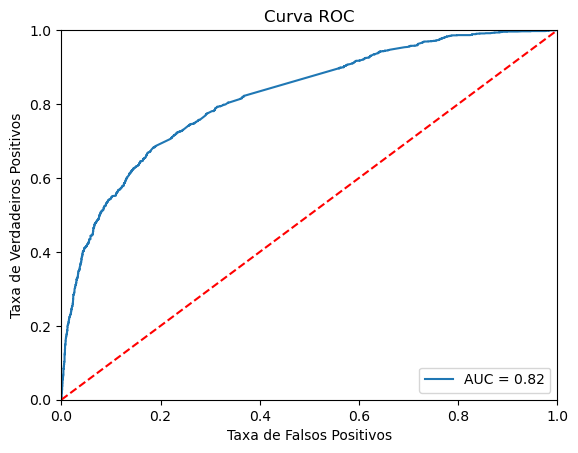

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Faz previsões no conjunto de teste utilizando o modelo treinado
y_pred_prob = modelGBC.predict_proba(X_test)[:,1]
# Calcula a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Calcula a área sob a curva ROC (AUC)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plota a curva ROC
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### b. Utilizando o modelo Floresta Aleatória


#### i. Encontre as 10 palavras mais importantes desse modelo


In [39]:
# Obter as importâncias das palavras
importances = modelRF.feature_importances_

# Obter o nome de cada palavra
words = vectorizer.get_feature_names_out()

# Criar uma lista de tuplas (palavra, importância)
feature_importances = [(word, importance) for word, importance in zip(words, importances)]

# Ordenar a lista pelo valor da importância em ordem decrescente
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Imprimir as 10 palavras mais importantes
print("As 10 palavras mais importantes do modelo são:")
for word, importance in feature_importances[:10]:
    print(f"{word}: {importance:.4f}")

As 10 palavras mais importantes do modelo são:
miss: 0.0384
sorry: 0.0338
sucks: 0.0331
hate: 0.0293
love: 0.0277
sad: 0.0273
happy: 0.0209
bad: 0.0206
not: 0.0203
stupid: 0.0196


    Podemos ver que apesar do modelo ter tido um desempenho ruim, as palavras mais importantes para detectar um comentário "negativo" fez total sentido

#### ii. Encontre 5 casos onde o modelo errou a classificação no conjunto de teste, mostrando a classificação real e predita, assim como o tweet em questão


In [49]:
# Fazer previsões no conjunto de teste
y_pred = modelRF.predict(X_test)

# Identificar casos onde a previsão do modelo está incorreta
wrong = np.where(y_test != y_pred)[0]
X_original = vectorizer.inverse_transform(X_test)
for i in range(5):
    print(X_original[wrong[i]])
    #textos_originais = vetorizador.inverse_transform(matriz_numerica)



['big' 'go' 'my' 'plans' 'thanks' 'there' 'tonsils']
['but' 'cream' 'expensive' 'ice' 'it' 'now' 'so' 'want']
['and' 'apartment' 'being' 'er' 'horrible' 'houston' 'in' 'is' 'monday'
 'moved' 'my' 'now' 'on' 'real' 'starting' 'to' 'twitter' 'work' 'world']
['am' 'be' 'fun' 'going' 'is' 'it' 'make' 'not' 'so' 'stop' 'tired' 'to'
 'tonight' 'why']
['and' 'been' 'has' 'have' 'scary' 'sore' 'spain' 'throat' 'to']


['big' 'go' 'my' 'plans' 'thanks' 'there' 'tonsils']
['but' 'cream' 'expensive' 'ice' 'it' 'now' 'so' 'want']
['and' 'apartment' 'being' 'er' 'horrible' 'houston' 'in' 'is' 'monday'
 'moved' 'my' 'now' 'on' 'real' 'starting' 'to' 'twitter' 'work' 'world']
['am' 'be' 'fun' 'going' 'is' 'it' 'make' 'not' 'so' 'stop' 'tired' 'to'
 'tonight' 'why']
['and' 'been' 'has' 'have' 'scary' 'sore' 'spain' 'throat' 'to']

## 8. Comentários e discussão


### a. Discorra sobre o que você aprendeu com essa atividade, bem como eventuais dúvidas ou comentários


    Achei a atividade bem interessante e dessa vez não foi tão dificil em termos de teoria, mas sim em termos de tempo de espera. Como já citei diversas vezes ao decorrer do trabalho eu não tenho um pc muito bom e por isso as demoras nos testes dos modelos foram extremamente grandese tive que realizar algumas mudanças no trabalho para conseguir enviar a tempo. Tirando as dificuldades com o treinamento o trabalho em si foi bem interessante e eu nunca tinha antes realizado nada de classificação, achei legal comparar os diversos modelos e assim como diferentes métodos de separação de variaveis. Acredito que faltou uma boa parte do trabalho com os dados (poderiamos muito bem ter utilizado a coluna "selected_text" a qual já tinha sido revisada anteriormente).
    
    Utilizando essa outra coluna muito provavelmente os treinamentos teriam sido mais rápidos e eficazes.

### b. Quais limitações você enxerga na abordagem utilizada?

    A limitação mais presente para mim no trabalho inteiro foi o custo computacional, onde a gente tinha uma linha com 16mil colunas as quais teriam que ser testadas linha por linha pra treinar um modelo que já é complexo. Além de que se tivessemos alguma palavra no conjunto de teste que não estivesse no conjunto de treino os algoritmos iriam simplesmente ignorar a mesma. Acho que faltou realizar um trabalho melhor no processamento dos dados iniciais, mas que mesmo assim deu um bom resultado considerando as mudanças feitas por mim no decorrer do trabalho.